In [1]:
from scipy.stats import norm
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import brentq
from scipy.stats import norm
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib.cm as cm

# Configuration variables
ticker = 'ATVI'

# Black-Scholes call and put price
def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

# Black-Scholes d1 and d2
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return [d1, d2]

# Fetch ticker and options expiration dates
comp = yf.Ticker(ticker)
exp_dates = comp.options

curr_price = comp.history(period='1d')['Close'][0]

# Latest 10 year yield for option price calculation
ten_yr_raw = web.DataReader('DGS10', 'fred', start=datetime(2021, 1, 1))
last_ten_yr = ten_yr_raw.iloc[-1].values[0]


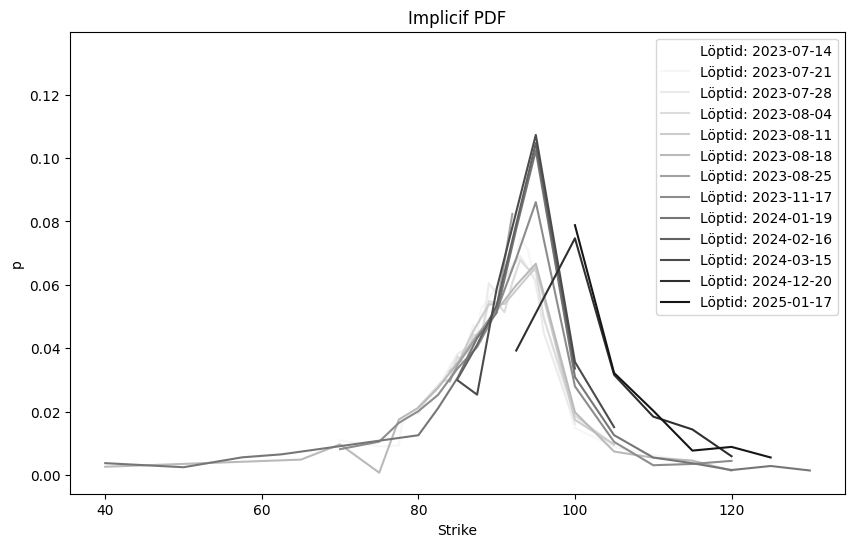

In [2]:


# Brents method objective function
def objective(sigma, *args):
    S, K, r, t, market_price, option_type = args
    d1, d2 = d(sigma, S, K, r, t)
    if option_type == "call":
        model_price = call_price(sigma, S, K, r, t, d1, d2)
    elif option_type == "put":
        model_price = put_price(sigma, S, K, r, t, d1, d2)
    return model_price - market_price

# Black Scholes PDF
def calculate_pdf(K, r, T, sigma, S):
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    pdf = np.exp(r * T) * norm.pdf(d2) / (S * sigma * np.sqrt(T))
    return pdf

pdfs_all = []
strikes_all = []

# Loop through all exp_dates to calculate pdf for each strike
for exp_date in exp_dates:
    options = comp.option_chain(exp_date)
    call_ivs = []
    strikes = []
    for index, row in options.calls.iterrows():
        t = (pd.to_datetime(exp_date) - datetime.now()).days / 365.0
        r = last_ten_yr / 100
        S = curr_price
        K = row['strike']
        market_price = row['lastPrice']
        try:
            implied_vol = brentq(objective, 0.01, 5, args=(S, K, r, t, market_price, "call"))
            call_ivs.append(implied_vol)
            strikes.append(K)  # Add strike
        except ValueError:
            pass  # If we can't solve for implied vol, skip the strike

    # Calculate PDF for each strike
    pdfs = []
    for i in range(len(call_ivs)):
        pdf = calculate_pdf(strikes[i], r, t, call_ivs[i], S)
        pdfs.append(pdf)
    
    # Save pdfs and strikes for each exp_date
    pdfs_all.append(pdfs)
    strikes_all.append(strikes)

# Plot PDF for each exp_date
plt.figure(figsize=(10,6))

# Create a color map
cmap = cm.get_cmap('Greys')

for i in range(len(exp_dates)):
    color = cmap(i / len(exp_dates))  # Generate a color based on the index
    plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color=color)

plt.title('Implicif PDF')
plt.xlabel('Strike')
plt.ylabel('p')
plt.legend()
plt.show()

# Plots of implicit PDFs based on the option data

We choose the chains 2023-07-21 and 2024-01-19 because they're the most liquid ones.

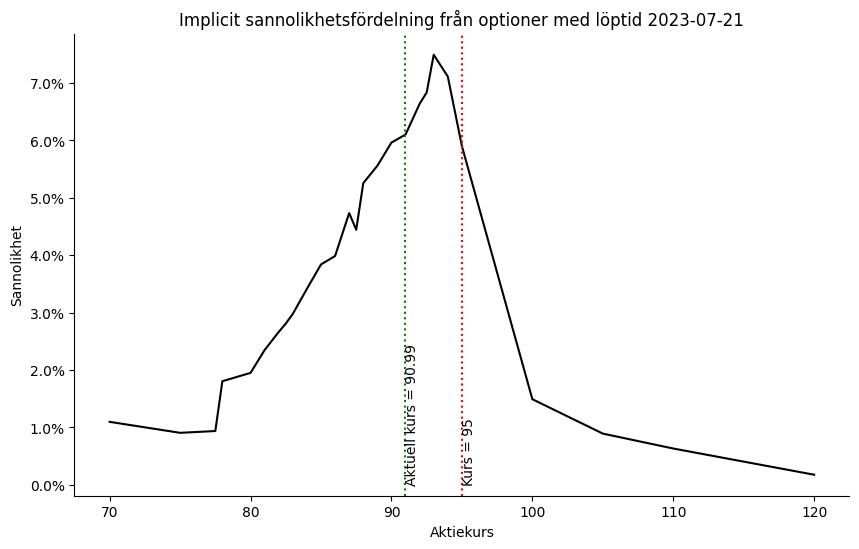

In [3]:
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2023-07-21':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2023-07-21')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')

ax = plt.gca()
vals = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(vals))
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(x=95, color='r', linestyle='dotted')
plt.text(95, 0.0005, 'Kurs = 95', rotation=90)
plt.axvline(x=curr_price, color='g', linestyle='dotted')
plt.text(curr_price, 0.0005, f'Aktuell kurs = {curr_price:.2f}', rotation=90)
plt.show()


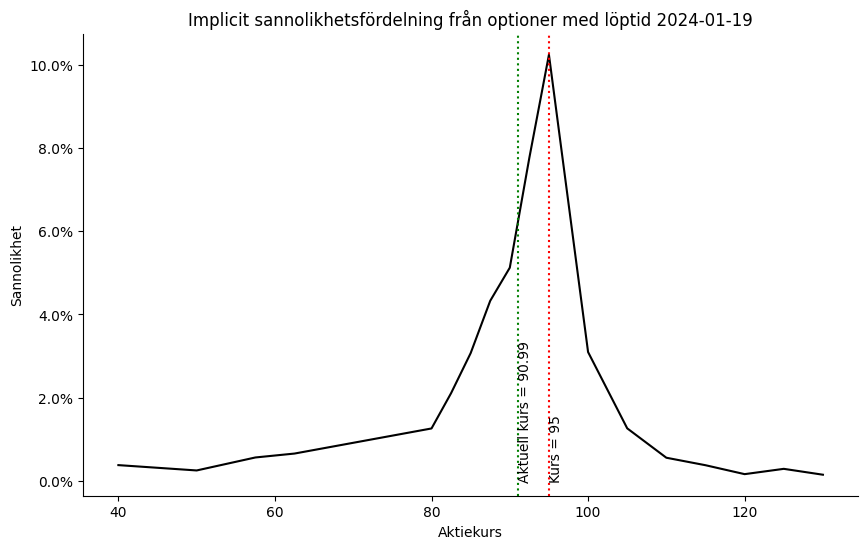

In [4]:
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2024-01-19':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2024-01-19')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')

ax = plt.gca()
vals = ax.get_yticks()
ax.yaxis.set_major_locator(FixedLocator(vals))
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.axvline(x=95, color='r', linestyle='dotted')
plt.text(95, 0.0005, 'Kurs = 95', rotation=90)
plt.axvline(x=curr_price, color='g', linestyle='dotted')
plt.text(curr_price, 0.0005, f'Aktuell kurs = {curr_price:.2f}', rotation=90)
plt.show()


Calculate the probabilities of the underlying asset price based on the Black-Scholes model and option chain data from Yahoo Finance.

In [5]:
from scipy.integrate import quad
import numpy
import scipy

# Find the index of the expiry date
expiry_date = '2024-01-19'
index = exp_dates.index(expiry_date)

# Find the corresponding strikes and pdfs
strikes = strikes_all[index]
pdfs = pdfs_all[index]

# Integrate the pdfs over all strikes, should be close to 1
total_sum_of_pdfs = numpy.trapz(pdfs, strikes)

# Integrate the pdfs over strikes greater than 95 with trapz and simps methods
strikes_array = numpy.array(strikes)
pdfs_array = numpy.array(pdfs)
sum_of_pdf_above_strike = numpy.trapz(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95])
print(f'Total sum of PDFs: {total_sum_of_pdfs:.2f}')


print(f'P(X >= 95) = {sum_of_pdf_above_strike/total_sum_of_pdfs:.2f} with \'trapz\' method')
print(f'P(X >= 95) = {scipy.integrate.simps(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95]):.2f} with \'simps\' method')

Total sum of PDFs: 1.51
P(X >= 95) = 0.36 with 'trapz' method
P(X >= 95) = 0.52 with 'simps' method
